<a href="https://colab.research.google.com/github/vanislekahuna/wps-labs/blob/main/BC_Wildfire_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BC Wildfire Mapping Tutorial**

<img src="https://images.squarespace-cdn.com/content/v1/5c0752d3cc8fedf5a8d40280/1654700933900-0KPHPHXUM9978DAXZ3OV/Husky_scratched_and_burned-e1633119048727.jpg?format=750w" width=800>


[Photo Source](https://www.huskyhavenfl.org/hhofl-blog/2022/5/2/the-abcs-of-burns-in-dogs)

## Introduction

In Canada's westernmost province, British Columbia, the uptick in the severity and occurrence of wildfires have caused substantial damage to the social and ecological systems in the province. For instance, in 2023 alone, 2,245 total wildfires burned in the province amounting to 2.84 million hectares of land going up in smoke (BC Public Service, 2023). Although British Columbia is a large region in terms of land mass with diverse terrain, the total acres burnt was truly an anomaly as it had more than doubled the previous record of 1.215 million acres in 2018 (BC Public Service, 2023). As a result of these wildfires, tens of thousands of people were forced to evacuate their homes. While those fortunate were able to flee from the crisis, there were plenty of other living creatures who didn't have the means, ability, or fortune to escape such an agonizing fate. And so far, no estimates have been released on the amount of wildlife that perished in those flames.

Whether a wildfire was caused through natural means like lightning strikes or by humans, detecting it and estimating its perimeter is one of the most challenging, yet impactful ways to minimize their destruction. One reason the early detection of a wildfire can be so impactful is that those that spark in remote forests can grow to unmanageable proportions before they spread close enough to an urban centre for locals to report it. Especially when we have a province as large as British Columbia with vast amounts of terrain such as dense forests, rocky mountains, or dry grasslands, communities on the ground may not be able to detect wildfires as easily if they start in a remote area until it's already burnt hundreds, or even thousands, of acres and wildlife. As an example, on May 12th, 2023, a lightning strike in [Donnie Creek](https://maps.app.goo.gl/c6zBveq2N529DkHX9) which is an area about 136 km southeast of the nearest urban centre, Fort Nelson, lit the fuse for a wildfire to burn about 5,700 square km before it was finally contained (Kulkarni, 2023).

However, with the recent advances in satellite technology and remote sensing techniques, we can now combine raw images from various orbiting satellites with maps to build estimations of a wildfire perimeter. In this article, we'll use the raw images from the Sentinel-2 and the GOES-16/17 satellites stored in the [Google Cloud Earth Engine data catalogue](https://developers.google.com/earth-engine/datasets/catalog/NOAA_GOES_16_FDCF#bands) to build a wildfire perimeter that we can overlay on a map that serves as a reference point to urban centres and other significant landmarks. By accessing image data from various satellite sources, we can highlight the strengths and weaknesses of the two approaches to have a broader foundation in wildfire detection and remote-sending more broadly.

Let's begin.

<img src="https://ichef.bbci.co.uk/news/1024/cpsprodpb/414E/production/_109781761_gettyimages-1188627293.jpg.webp" width=800>


[Photo Source](https://www.bbc.com/news/world-australia-50511963)

First, a bit of bookkeeping. Let's ensure that we're using the same versions of packages required in this article to ensure reproducibility and to follow coding best practices.

In [2]:
# !pip install earthengine-api==0.1.406
# !pip install folium==0.14.0
# !pip install geemap==0.32.1 #Backup version: 0.20.4
# !pip install matplotlib==3.7.1
# !pip install numpy==1.25.2
# !pip install pandas<2.7.0

In [3]:
import ee
import folium
import geemap.core as geemap # import geemap
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime
from zoneinfo import ZoneInfo

Next, we'll need to authenticate our Google accounts so that we're able to access the images and computing power associated with this task. For our teaching purposes, we should be able to access the resources we need for free. For those who don't yet have a Google cloud project set up to access the Earth Engine API, here's a [quick guide](https://medium.com/p/fe5472ddbaeb#620c-fb99daf8c065) on how to get started. We'll need a project account name associated to the Earth Engine (`ee`) library to access the compute and data required for the rest of our code to run.

Now, enter Google cloud project name credentials in the `project` argument to authenticate our Earth Engine account.

In [6]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project="{enter-project-name}") #My project name: "bc-wildfire-422905"

With our libraries and packages set up, let's now zoom in on a particular area of interest. One major fire we can study was the tragic [Lytton Creek wildfire](https://en.wikipedia.org/wiki/Lytton_wildfire) which began on June 30th, 2021 and ravaged for several weeks (Lindsay & Dickson, 2021). The outcome left about 2,000 residents without a home as the fire burned down the entire village and killed two people in the process (Lindsay & Dickson, 2021).

The cause of the fire stemmed from a recipe of extreme climate events which severely elevated the risk of natural disasters in the area. For starters, just the day before the wildfire started, Lytton set an all-time record of having the highest temperature ever recorded in Canada with a high of 49.6$^{\circ}$ that day. Under those extreme drought conditions with winds travelling up to 71 km an hour that day, the fire spread incredibly fast leaving residents and firefighters with little time to prepare for the fire.

To get a first-hand glance at the severity of the Lytton Creek wildfire, let's start by pulling images from the Sentinel-2 satellite. For the rest of this analysis, we'll use the following latitude and longitude coordinates of the old Lytton library as the central point of our satellite data, specify a 40 km radius for GOES satellites, and a time range between `2024-06-15` and `2024-07-15` so that we have a view of Lytton before and after the fire. With our Sentinel-2 data, the 40km radius won't matter as much as when we explore the images from the GOES satellites because, as we'll see shortly, it takes large snapshots of the areas below which covers large sections of land.

In [7]:
# Getting coordinates of the point of interest
# which is the Lytton library as the poi for the Lytton Creek wildfire that started on 2021-06-30
lat =  50.23124506328952
lon = -121.58154057521354

# start date of range to filter for
start_date = "2021-06-15"

# end date
end_date = "2021-07-15" #"2021-10-31"

# radius of interest in meters
radius_of_interest_meters = 40000

# point of interest as an ee.Geometry
poi = ee.Geometry.Point([lon, lat]).buffer(radius_of_interest_meters)

datetime_format = "%Y-%m-%d %H:%M:%S"

## Data Extraction (Part 1)

### Extracting Sentinel-2 satellite data

Before we go further, let's do a brief overview of what Sentinel-2 is and how it differs from other satellites. **Sentinel-2** is a set of twin satellites deployed by the European Space Agency with the stated mission of gaining a "new perspective of our land and vegetation" through its 13 spectral bands (European Space Agency, 2024).

For those new to satellite imaging or remote sensing, **spectral bands** refer to the wavelength of light that is either reflected or absorbed from the Earth's surface and can be detected through satellite sensors. Examples of bands we'll be using here include short-wave infrared (SWIR) bands, near-infrared (NIR) bands, and red, green, and blue bands. In the context of remote sensing, we can analyze the light from these bands to make inferences about the state of the Earth's surface. Not only can we use this information to determine the location of wildfires, but we can also use it to ascertain information about an area's water quality or quantify its amount of forest cover.

The way that Sentinel-2 gathers data is by orbiting around the Earth and taking snapshots of the surface approximately every 5 days (European Space Agency, 2024). Each image covers about 290 km which is great because it allows us to monitor large swaths of land with just a single image, given that it's clear and largely free from clouds or smoke blocking the surface.

In addition to the image data, we'll also make use of some functions written by Justin Braaten (2022) and his team at Google to aid us in our analysis. The first is the `mask_s2_cloud()` function which helps us reduce the noise from the cloud for clearer imaging (Braaten, 2022). The second is the `add_ee_layer()` which essentially allows us to overlay satellite images on top of a Google map-like interface from the `folium` package so that we're able to cross-reference our raw image data with all the symbols and markers we'd typically see on a map (Braaten, 2022).

In [8]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select("QA60")

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [9]:
# Google function that allows ee layers on folium
def add_ee_layer(self, ee_image_object, vis_params, name):
    """
    Adds a method for displaying Earth Engine image tiles to folium map.
    """

    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium
folium.Map.add_ee_layer = add_ee_layer

With our date and geocoordinate parameters, we should extract about 27 [Sentinel-2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#description) satellite images from the Google Earth Engine data catalogue and store it in our `s2_dataset` object.

In [10]:
s2_dataset = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(start_date, end_date).filterBounds(poi).filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)).map(mask_s2_clouds)

# how many images did we get?
print("Total number:", s2_dataset.size().getInfo())

Total number: 27


In [11]:
# Getting a feel of the resulting data structure
s2_dataset.first().getInfo()

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32610',
   'crs_transform': [60, 0, 499980, 0, -60, 5600040]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32610',
   'crs_transform': [10, 0, 499980, 0, -10, 5600040]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32610',
   'crs_transform': [10, 0, 499980, 0, -10, 5600040]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32610',
   'crs_transform': [10, 0, 499980, 0, -10, 5600040]},
  {'id': 'B5',
   'data_type': 

If we look at each of the 27 images pulled from the Earth Engine bucket, we'll find that the image quality on most of them isn't great as there are often clouds or smoke blocking our view of Lytton. Therefore, we've decided to manually select those with the best image quality, store the list in our `interesting_images` object, and display them to get a visual of the raw images we'll be working with.

In [12]:
s2_params = {
      "bands": ["B4", "B3", "B2"],  # True color (RGB)
      "min": 0,
      "max": 0.3,  # Adjust min and max values as needed
      "dimensions": 512,
      "region": poi
  }

# Generating an image list for s2 data
s2_image_list = s2_dataset.toList(s2_dataset.size())

# Selecting the images with decent quality
# To access all the scraped images, replace the following objects:
# interesting_images = range(s2_dataset.size().getInfo())
interesting_images = [5, 9, 11, 12, 15, 18, 26]

for i in interesting_images:
  try:

    # Extract the timestamp string
    s2_property = s2_image_list.get(i).getInfo()
    timestamp_str = s2_property["properties"]["system:index"].split("_")[0]

    # Convert to datetime object
    datetime_obj = datetime.strptime(timestamp_str, "%Y%m%dT%H%M%S")

    # Make the datetime timezone-aware (UTC)
    dt_utc = datetime_obj.replace(tzinfo=ZoneInfo("UTC"))

    # Convert to Pacific Time
    pacific_tz = ZoneInfo("America/Los_Angeles")
    dt_pacific = dt_utc.astimezone(pacific_tz).strftime(datetime_format)

    print(f"Image #{i} / Date: {dt_pacific} PST/PDT")

    s2_image = ee.Image(s2_image_list.get(i))
    s2_url = s2_image.getThumbUrl(s2_params)
    display(Image(url=s2_url))

  except:
    pass

Image #5 / Date: 2021-06-26 11:59:19 PST/PDT


Image #9 / Date: 2021-06-29 12:09:19 PST/PDT


Image #11 / Date: 2021-07-01 11:59:21 PST/PDT


Image #12 / Date: 2021-07-01 11:59:21 PST/PDT


Image #15 / Date: 2021-07-06 11:59:19 PST/PDT


Image #18 / Date: 2021-07-09 12:09:19 PST/PDT


Image #26 / Date: 2021-07-14 12:09:21 PST/PDT


### Data Transformation: Applying Normalized Burn Ratio (NBR) layers from extracted images

Now that we've extracted our raw images, we can see how difficult it is to spot activity from the naked eye. This is where the importance of spectral bands comes into play. Since Sentinel-2 is capable of gathering data from shortwave infrared (SWIR) and near-infrared (NIR) bands, we can use a combination of the two to transform our image data and give us a better understanding of the area that's been burnt (or burning).

What we're describing here is a **normalized burn ratio (NBR)** which uses the following formula to identify the burned areas in a particular and visually quantify the severity of the burn:

$$ NBR = (NIR - SWIR) / (NIR + SWIR) $$

The NBR formula uses the difference between NIR and SWIR reflectance, normalized by their sum, to quantify burned areas based on the numerical values we observe from the NIR and SWIR bands (United Nations, n.d.). Without going too deep into the maths, let's briefly describe the purpose of each underlying band.

**Near-infrared (NIR)** light is often reflected the more healthier or greener the vegetation is on a given land surface. In areas that have been burnt, we'll see less of this spectral wave reflected from the Earth's surface (United Nations, n.d.).

On the other hand, **short-wave infrared (SWIR)** light is reflected based on the moisture content of the underlying surface. Areas with high moisture, and presumably healthier vegetation, tend to absorb this spectral wavelength which means less of it is reflected and picked up by our satellites (United Nations, n.d.). In contrast, drier areas will reflect higher levels of SWIR light since there is less capability to absorb it.

The contrast between these two bands helps us easily distinguish between areas with healthy and burnt vegetation in addition to the severity of the burn (United Nations, n.d.). The resulting NBR values we can observe from this equation range from -1 to 1 where:

- Negative values often indicate bare ground or recently burned areas
- Values close to zero indicate urban or water areas
- Positive values typically represent vegetated areas

In [13]:
# Function to calculate NBR
def calculate_nbr(image):
  """
  Calculate the Normalized Burn Ratio (NBR) for a given satellite image using the Near-Infrared (NIR) and Short-Wave Infrared (SWIR) bands,
  typically used for burn severity assessment in wildfire studies.

  NBR = (NIR - SWIR) / (NIR + SWIR)

  The resulting value typically range from -1 to 1, where:
    * Negative values often indicate bare ground or recently burned areas
    * Values close to zero indicate urban or water areas
    * Positive values typically represent vegetated areas
  """
  nbr = image.normalizedDifference(["B8", "B12"]).rename("NBR")
  return image.addBands(nbr)

### Data Visualization

Now that we have a better understanding of NBR, let's apply it to each of the "interesting images" we've extracted from Sentinel-2 and layer them over an open-source map.

In [14]:
# Apply NBR calculation
s2_nbr = s2_dataset.map(calculate_nbr)

# Get the first image and visualize
s2nbr_list = s2_nbr.toList(s2_nbr.size())

s2_vis_params = {
    # B4 = Red band - useful for calculating vegetation indices
    # B8 = Near Infrared (NIR) band - also useful for calculating vegetation and burn severity.
    # B12 = Shortwave Infrared (SWIR) band - great for detecting fires and hot spots.
    "bands": ["B12", "B8", "B4"], # Ash's bands: ["B12", "B11", "B9"]
    "min": 0.0,
    "max": 0.3,
    "gamma": 1.4
}


# Create a map
wildfire_map = folium.Map(location=[lat, lon], zoom_start=10)

# Add a layer for each satellite image of interest (before, during and after)
for i in interesting_images:

  # Extract the timestamp string
  s2nbr_list_property = s2nbr_list.get(i).getInfo()
  timestamp_str = s2nbr_list_property["properties"]["system:index"].split("_")[0]

  # Convert to datetime object
  s2_datetime = datetime.strptime(timestamp_str, "%Y%m%dT%H%M%S")

  # Make the datetime timezone-aware (UTC)
  dt_utc = s2_datetime.replace(tzinfo=ZoneInfo("UTC"))

  # Convert to Pacific Time
  pacific_tz = ZoneInfo("America/Los_Angeles")
  s2_datetime_pst = dt_utc.astimezone(pacific_tz).strftime(datetime_format)

  # Image title
  title = f"Sentinel-2 SWIR Image #{i} / Date: {s2_datetime_pst} PST/PDT"

  # Extract the image from the list
  s2_nbr_image = ee.Image(s2nbr_list.get(i))

  # Add the image layerto the map
  wildfire_map.add_ee_layer(s2_nbr_image, s2_vis_params, name=title)

# Add a layer control panel to the map
folium.LayerControl(collapsed=False).add_to(wildfire_map)

# Display the map.
display(wildfire_map)

From the NBR-transformed, satellite imaging we collected of the area surrounding Lytton between June to July 15th, we can see distinct areas that were ravaged by the fires in 2021. Removing all the layers by de-selecting the images gives us a bearing on where the town of Lytton is in the satellite image.

However, if we select image layers #9, 11, 12, and 26, we'll find another fire perimeter northeast of Lytton, one that looks slightly larger. Because the Sentinel-2 images cover such a large area and with some further research, we were surprisingly able to discover that the [Sparks Lake wildfire](https://www.eoas.ubc.ca/courses/atsc413/cases/sparks_lake_BC/index.html) was another natural disaster occurring the same time as our Lytton Creek wildfire on June 29th, 2021 (Watson & Lindsay, 2021). The Sparks Lake wildfire also turned out to be one of B.C.'s most devastating fires in history due to the heat dome the province experienced that year. The fire appeared to have been human-caused by a nearby marijuana growth operation which burned down about 960 km$^2$ for 69 days before firefighters eventually got control of it.


While the data from Sentinel-2 does a fine job in identifying and mapping out burnt areas of the region, it suffers some heavy drawbacks in its inability to provide real-time information to emergency responders and members of the public. Because Sentinel-2 needs time to orbit and image other areas of the globe, there is a 2-5 day lag between every snapshot at a particular point of interest (POI), depending on how close it is to the equator (European Space Agency, 2024). In situations where a natural disaster is unfolding rapidly and emergency responders need prompt access to information for rapid and high-stakes decisions, Sentinel-2 data will not be sufficient for this purpose so we must turn to other tools to fill the gap.

Additional concerns with Sentinel-2 images are the presence of clouds or smoke over our POI which can massively reduce the image quality because they limit the amount of light the Earth can reflect to its sensors. Sentinel-2 is also limited to operating during the day due to its reliance on sunlight so any opportunity to gather data at night is out of the question.

## Data Extraction (Part 2)

### Extracting GOES-16 & GOES-17 satellite data

As we've explored the strengths of the Sentinel-2 data and highlighted its weaknesses, luckily, we have other systems to shore up these vulnerabilities such as the GOES-16 and GOES-17 satellites. The [**Geostationary Operational Environmental Satellites (GOES)**](https://www.goes-r.gov/downloads/resources/documents/Beginners_Guide_to_GOES-R_Series_Data.pdf) are a set of geostationary satellites which takes high temporal resolution images every 5-15 min, with each pixel having a resolution of about 0.5 to 2 km (NOAA & NASA, 2024). When we refer to a satellite as *geostationary*, it means that it orbits the Earth in the same direction about 35,000 km above the equator and at about the same speed so that from the perspective of a ground-bound observer, the satellite appears nearly stationary. Among the two satellites we mentioned earlier, GOES-16 does the majority of the image capture over the North and South American continent while GOES-17 functions as a ready spare when necessary (NOAA & NASA, 2024).

On board each GOES satellite is the [Advanced Baseline Imager (ABI)](https://www.goes-r.gov/spacesegment/abi.html) instrument for imaging the Earth's weather, oceans, and environment through its 16 different spectral bands (NOAA & NASA, n.d.). While tracking the flow of wildfire is the use case we're most interested in, these satellites can also provide independent data sources for monitoring things like cloud formation, land surface temperature, ocean dynamics, volcanic ash plumes, vegetative health and more. Because our GOES satellites can take snapshots every 5-15 minutes, decision-makers can rely on the monitoring and fire perimeter we build from this data to inform their emergency response. In contrast to Sentinel-2, GOES satellites are also capable of gathering data 24/7 through their thermal infrared bands which do not rely on sunlight (NOAA & NASA, n.d.). Additionally, it is also capable of penetrating cloud cover by snapping images during windows where the cover is less dense (NOAA & NASA, n.d.).

Now that we've gotten the brief overview of the GOES-16/17 satellites out of the way, let's start extracting data again from the [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/NOAA_GOES_16_FDCF#bands) using the same parameters we used earlier to locate the Lytton Creek wildfire during the end of June 2021. As we can see, we extracted over 4,000 images from each satellite due to its ability to snap images in lightning-quick 5-15 minute intervals.

In [15]:
# Gathering satellite data
goes_16 = ee.ImageCollection("NOAA/GOES/16/FDCF").filterDate(start_date, end_date).filterBounds(poi)

goes_17 = ee.ImageCollection("NOAA/GOES/17/FDCF").filterDate(start_date, end_date).filterBounds(poi)

# Example: print the number of images in the collections (optional)
print(f"Number of GOES-16 images: {goes_16.size().getInfo()}")
print(f"Number of GOES-17 images: {goes_17.size().getInfo()}")

Number of GOES-16 images: 4273
Number of GOES-17 images: 4245


In [16]:
# Getting a feel for the data we've extracted from the Earth Engine dataset
pprint.pp(goes_17.first().getInfo())

{'type': 'Image',
 'bands': [{'id': 'Area',
            'data_type': {'type': 'PixelType',
                          'precision': 'int',
                          'min': -32768,
                          'max': 32767},
            'dimensions': [5424, 5424],
            'crs': 'PROJCS["unnamed", \n'
                   '  GEOGCS["unknown", \n'
                   '    DATUM["unknown", \n'
                   '      SPHEROID["Spheroid", 6378137.0, 298.2572221]], \n'
                   '    PRIMEM["Greenwich", 0.0], \n'
                   '    UNIT["degree", 0.017453292519943295], \n'
                   '    AXIS["Longitude", EAST], \n'
                   '    AXIS["Latitude", NORTH]], \n'
                   '  PROJECTION["GEOS"], \n'
                   '  PARAMETER["central_meridian", -137.0], \n'
                   '  PARAMETER["satellite_height", 35786023.0], \n'
                   '  PARAMETER["false_easting", 0.0], \n'
                   '  PARAMETER["false_northing", 0.0], \n'
       

Let's also load the `map_from_map_codes_to_confidence_values()` and `apply_scale_factors()` functions the team at Google [provided us](https://medium.com/google-earth/how-to-generate-wildfire-boundary-maps-with-earth-engine-b38eadc97a38) to process our data.

In [17]:
def map_from_mask_codes_to_confidence_values(image):
    return image.clip(poi).remap(fire_mask_codes, confidence_values, default_confidence_value)

In [18]:
# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select("SR_B.").multiply(0.0000275).add(-0.2)
  thermal_bands = image.select("ST_B.*").multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )

#### Overview of the Fire Detection Characterization (FDC) Algorithm

Now that we've talked a little bit about the satellites used to generate the data, let's discuss how we are to detect the presence of wildfires based on these images. Luckily for us, Google makes this easy by giving developers easy access to the [FDC Fire Detection algorithm](https://www.star.nesdis.noaa.gov/goesr/docs/ATBD/Fire.pdf) which was developed by a research team at the University of Wisconsin-Madison.

The primary objective of the **FDC Fire Detection algorithm** is to return the likelihood of a fire based on the pixel data of an input image (Restif & Hoffman, 2020). For those interested, below is a brief overview of the steps that the FDC Fire detection algorithm takes to accomplish this objective:

1) First, the algorithm takes the data from the **thermal infrared (TIR)** band of the satellite sensor (band 14), as well as the **shortwave infrared (SWIR)** band (7), and converts the brightness of each pixel to a temperature;

2) Next, it flags certain TIR pixels based on whether they exceed a certain threshold. Examples of such thresholds include:
- *Absolute threshold* based on a set temperature;
- *Relative threshold* based on the delta between a pixel's temperature and its neighbour's exceeding a set amount.

3) If a pixel is flagged, it checks for false positives by evaluating the temperature of its neighbouring pixels just like in the previous step. When checking the temperature of the pixel, we can choose to apply a different threshold from step 2 if we wish. And in the case of our code example below, we do just that by applying a relative threshold instead.

4) If our neighbouring pixel also exceeds the threshold, it will then apply one last check for false positives by evaluating whether the *delta/difference* between the pixel temperature produced by the TIR (band 14) and the SWIR (band 7) band exceeds a relative threshold.

5) And if the difference between the TIR and SWIR pixel temperatures exceeds our relative threshold, the algorithm will return a 1 or a `True` result, confirming that the pixel in question is indeed a fire pixel.

Our code below is a simplified demonstration of Steps 1-5 of the FDC algorithm. However, our explanation only covers the presence of a fire based on the pixel's brightness so the final result of our simplified FDC algorithm is a binary `True`/`False` value.

In [19]:
# Fire Detection Characterization (FDC) Algorithm example implementation

# Simulated satellite image data
def create_simulated_data(width=50, height=50):

    # Create background temperature (avg 290 Kelvin or 16.85 degrees Celsius)
    background = np.random.normal(290, 2, (height, width))

    # Add some hotter spots (potential fires) with temperatures between 310 to 330 Kelvins (i.e. 36.85 to 56.85 degrees Celsius)
    num_hotspots = 5
    for _ in range(num_hotspots):
        x, y = np.random.randint(0, width), np.random.randint(0, height)
        hotspot_temp = np.random.uniform(310, 330)
        background[y, x] = hotspot_temp

    return background

# Simplified FDC algorithm - our absolute thereshold is 310K or 36.85 degrees
def simplified_fdc(image_4um, image_11um, absolute_threshold=310, relative_threshold=10):
  height, width = image_4um.shape
  fire_mask = np.zeros((height, width), dtype=bool)

  for i in range(1, height-1):
      for j in range(1, width-1):
          # Step 1: Check absolute threshold
          if image_4um[i, j] > absolute_threshold:
              # Step 2: Calculate background
              background = np.mean(image_4um[i-1:i+2, j-1:j+2])

              # Step 3: Check relative threshold
              if image_4um[i, j] - background > relative_threshold:
                  # Step 4: Multi-channel confirmation
                  if image_4um[i, j] - image_11um[i, j] > 10:
                      fire_mask[i, j] = True

  return fire_mask

# Create simulated data
image_4um = create_simulated_data()
image_11um = image_4um - np.random.normal(10, 2, image_4um.shape)  # 11um channel is typically cooler

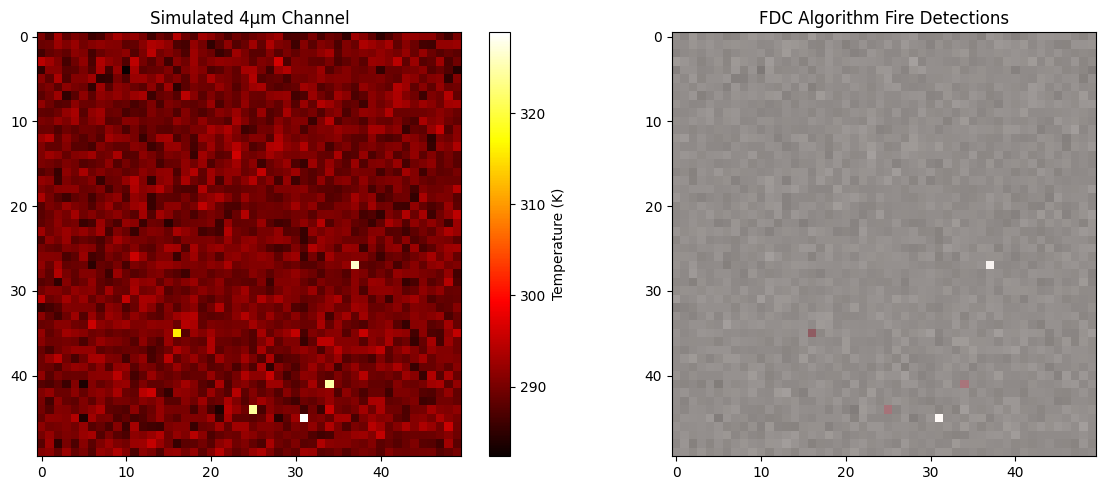

Number of fire pixels detected: 3


In [20]:
# Apply simplified FDC algorithm
fire_detections = simplified_fdc(image_4um, image_11um)

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

im1 = ax1.imshow(image_4um, cmap="hot")
ax1.set_title("Simulated 4μm Channel")
plt.colorbar(im1, ax=ax1, label="Temperature (K)")

ax2.imshow(image_4um, cmap="gray")
ax2.imshow(fire_detections, cmap="Reds", alpha=0.5)
ax2.set_title("FDC Algorithm Fire Detections")

plt.tight_layout()
plt.show()

print(f"Number of fire pixels detected: {np.sum(fire_detections)}")

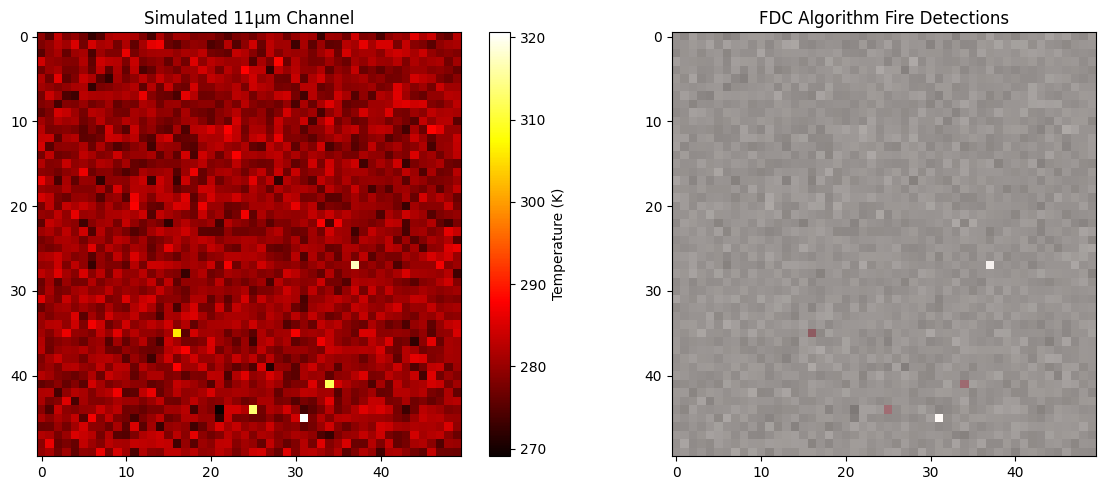

Number of fire pixels detected: 3


In [21]:
# Visualize results
fig1, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))

im2 = ax3.imshow(image_11um, cmap="hot")
ax3.set_title("Simulated 11μm Channel")
plt.colorbar(im2, ax=ax3, label="Temperature (K)")

ax4.imshow(image_11um, cmap="gray")
ax4.imshow(fire_detections, cmap="Reds", alpha=0.5)
ax4.set_title("FDC Algorithm Fire Detections")

plt.tight_layout()
plt.show()

print(f"Number of fire pixels detected: {np.sum(fire_detections)}")

### Data Transformation: Applying the Fire Detection Algorithm (FDC)

There are additional steps associated with the algorithm such as estimating its **fire radiative power (FRP)** which represents the brightness or intensity of a fire in the confirmed pixel. From there, the algorithm then assigns a confidence value towards the probability of an actual fire being reflected from the pixel and plots it on a map to build a fire perimeter.

For the sake of brevity, we can cover the complexities behind these confidence values in a future article so for now, take these explanations at face value. At this point in the code, we are now assigning `confidence_values` between 50-100% to the outputs produced by the algorithm. With a single output, if the algorithm returns a value of `15`, it's classifying it as a low probability fire pixel at 50% and in contrast, if it returns a value of `10`, there's a near 100% probability that it is a processed fire pixel (Restif & Hoffman, 2020). The resulting values from this process are captured in the `goes_16_confidence` and `goes_17_confidence` objects in the following code.

In [22]:
# Conversion from mask codes to confidence values.
fire_mask_codes = [10, 30, 11, 31, 12, 32, 13, 33, 14, 34, 15, 35]
confidence_values = [1.0, 1.0, 0.9, 0.9, 0.8, 0.8, 0.5, 0.5, 0.3, 0.3, 0.1, 0.1]
default_confidence_value = 0

# Processing the GOES-16 satellite images
goes_16_confidence = goes_16.select(["Mask"]).map(map_from_mask_codes_to_confidence_values)
goes_16_max_confidence = goes_16_confidence.reduce(ee.Reducer.max())

# Processing the GOES-17 satellite images
goes_17_confidence = goes_17.select(["Mask"]).map(map_from_mask_codes_to_confidence_values)
goes_17_max_confidence = goes_17_confidence.reduce(ee.Reducer.max())

### Data Visualization

Now, one last thing. Since the satellites collect data over a specific time range, the probability of a fire in a given pixel may vary greatly due to the evolving nature of the on-ground event. Although the temporal aspect of the data itself contains plenty of valuable information, in this instance, we're more concerned with generating a broad outline of the fire boundary. To do so, we can use the `ee.Reducer.max()` function to return the highest confidence value of each pixel within the specified time range (Restif & Hoffman, 2020). We'll apply this to both the `goes_16_confidence` and the `goes_17_confidence` objects before overlaying the specific pixel plots on our map below.

In [23]:
# We can visualize that initial data processing step from each satellite, using:
affected_area_palette = ["white", "yellow", "orange", "red", "purple"]

earth_engine_viz = {
    "opacity": 0.3,
    "min": 0,
    "max": 1,
    "palette": affected_area_palette
  }

# Create a map.
Map = geemap.Map()
Map.centerObject(poi, 9)
Map.addLayer(poi, {"color": "green"}, "Area of interest", True, 0.2)
Map.addLayer(goes_16_max_confidence, earth_engine_viz, "GOES-16 maximum confidence")
Map.addLayer(goes_17_max_confidence, earth_engine_viz, "GOES-17 maximum confidence")
Map

Map(center=[50.23128609777502, -121.58153879631847], controls=(ZoomControl(options=['position', 'zoom_in_text'…

From our initial results, we can see two iterations of the FDC Algorithm layered over top of each other on the map. We can combine the results of our two satellite images to increase the spatial resolution of our wildfire perimeter using the `ee.Reducer.min()` function which returns the lesser of the two confidence values where the two layers intersect (Restif & Hoffman, 2020).

In [24]:
# Combine the confidence values from both GOES-16 and GOES-17 using the minimum reducer
combined_confidence = ee.ImageCollection([goes_16_max_confidence, goes_17_max_confidence]).reduce(ee.Reducer.min())

# Create a map
Map = geemap.Map()
Map.centerObject(poi, 9)
Map.addLayer(poi, {"color": "green"}, "Area of interest", True, 0.2)
Map.addLayer(combined_confidence, earth_engine_viz, "Combined confidence")

# Display the map
Map

Map(center=[50.23128609777502, -121.58153879631847], controls=(ZoomControl(options=['position', 'zoom_in_text'…

With the results of our two satellites combined, notice how the generated boundary is highly pixelated due to the image quality of the satellites. One last thing we can do to our wildfire boundary is to smooth the boundaries between the combined fire masks using the `ee.Image.reduceNeighborhood()` function.

In [25]:
# Define the kernel for smoothing
kernel = ee.Kernel.square(2000, "meters", True)

# Apply the smoothing using reduceNeighborhood with the mean reducer
smoothed_confidence = combined_confidence.reduceNeighborhood(
    reducer=ee.Reducer.mean(),
    kernel=kernel,
    optimization="boxcar"
)

# Create a map
Map = geemap.Map()
Map.centerObject(poi, 9)
Map.addLayer(poi, {"color": "green"}, "Area of interest", True, 0.2)
Map.addLayer(smoothed_confidence, earth_engine_viz, "Smoothed confidence")

# Display the map
Map

Map(center=[50.23128609777502, -121.58153879631847], controls=(ZoomControl(options=['position', 'zoom_in_text'…

There you have it! A near real-time wildfire boundary using Python to deploy the FDC Algorithm on GOES-16 and 17 satellite images from Google's Data Catalog platform. However, as with most technologies, the use of the FDC on GOES-16/17 images doesn't come without its weaknesses which we'll discuss to have a better understanding of the situations where other technologies would be more appropriate.

One risk with using the FDC algorithm on GOES-16/17 images is its tendency to detect false positives with an image. For example, reflective surfaces from buildings in urban areas or lakes and dry vegetation in a forest may be misconstrued as a fire.

Additionally, the image resolution from GOES-16/17 satellites is poorer compared to other data collection techniques. We saw this first-hand from the pixelated fire perimeter we produced in our initial effort applying the FDC algorithm. The reason why the wildfire perimeter was so pixelated is because each pixel captures anywhere between 4-36 $km^2$ depending on how far the area is from the centre of the image. Due to the spherical shape of the Earth and the satellite's position, the farther an area is from the centre of an image, the lower its image quality. For wildfire detection, what this means is that activities smaller than the pixel size may either be mischaracterized or missed completely.

Another aspect to consider is the terrain of the area of interest. This risk is mostly attributed to mountainous terrain where the lee ward side of a mountain may obfuscate a satellite's view in that area.

To mitigate these risks, we must use other imaging techniques and technologies alongside GOES-16/17 data to gain a clearer understanding of the ground situation. As we've previously discussed, high-resolution data from Sentinel-2 and Landsat satellites can be highly complementary when they're available as it allows us to cross-validate our resulting wildfire boundaries. On top of that, ground observations and aerial drone surveys add another layer of validation to a highly dynamic event.

By executing the FDC algorithm on GOES-16/17 data, there's little doubt that this approach can be a powerful asset in helping us build wildfire perimeters in real time as part of a broader mitigation strategy with other sensory techniques.

If you've made it this far, thank you as always for taking the time to read through this tutorial! We hope that we played a role in reducing the barrier to entry in remote sensing and have empowered you with the tools to get started. As our summers get warmer and the proliferation of climate emergencies increases, the work of data science professionals will only become more essential in helping emergency teams save lives, protect property, and reduce suffering.

## Resources

- Braaten, J. (2022, January, 7). Sentinel-2 Cloud Masking with s2cloudless. *Google Earth Engine.* https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless

- BC Public Service. (2023, December 7). *Wildfire Season Summary*. https://www2.gov.bc.ca/gov/content/safety/wildfire-status/about-bcws/wildfire-history/wildfire-season-summary

- European Space Agency. (2024). S2 mission. https://sentiwiki.copernicus.eu/web/s2-mission

- Kulkarni, A. (2023, July 3). *What happens after the Donnie Creek wildfire, now larger than P.E.I., stops burning? CBC.* https://www.cbc.ca/news/canada/british-columbia/donnie-creek-wildfire-aftermath-1.6892294

- Lindsay, B. & Dickson, C. (2021, July 1). *Village of Lytton, B.C., evacuated as mayor says 'the whole town is on fire.' CBC.* https://www.cbc.ca/news/canada/british-columbia/bc-wildfires-june-30-2021-1.6085919

- National Oceananic and Atmospheric Association (NOAA) & National Aeronautics and Space Administration (NASA). (2024). Beginner's guide to GOES-R series data: How to acquire, analyze, and visualize GOES-R Series data. https://www.goes-r.gov/downloads/resources/documents/Beginners_Guide_to_GOES-R_Series_Data.pdf

- National Oceananic and Atmospheric Association (NOAA) & National Aeronautics and Space Administration (NASA). (n.d.). Instruments: Advanced baseline imager (ABI). https://www.goes-r.gov/spacesegment/abi.html

- Restif, C. & Hoffman, A. (2020, November 20). How to generate wildfire boundary maps with Earth Engine. *Medium*. https://medium.com/google-earth/how-to-generate-wildfire-boundary-maps-with-earth-engine-b38eadc97a38

- Schmidt, C., Hoffman, J., Prins, E., & Lindstrom, S. (2012, July 30). GOES-R Advanced Baseline Imager (ABI) algorithm theoretical basis document for
fire / hot spot characterization. NOAA NESDIS Center for Satellite Applications and Research. https://www.star.nesdis.noaa.gov/goesr/docs/ATBD/Fire.pdf

- Stull, R. & Rodell, C. (2023, November 18). Case: Sparks Lake, BC. *UBC Earth, Ocean, and Atomspheric Sciences.* https://www.eoas.ubc.ca/courses/atsc413/cases/sparks_lake_BC/index.html

- Watson, B. & Lindsay, B. (2021, June 29). *Homes evacuated as out-of-control wildfires grow in B.C.'s Interior CBC.* https://www.cbc.ca/news/canada/british-columbia/wildfires-interior-bc-1.6084445

- United Nations: Office for Outer Space Affairs. (n.d.). Normalized Burn Ratio (NBR). https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio